# LGBM with pycaret



In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime

# 데이터 가져오기

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
output_dir = '/opt/ml/p4-dkt-feedgate/lgbm_output/서일님'

train_path = os.path.join(data_dir, 'tuning_train_data_2.csv')
test_path = os.path.join(data_dir, 'tuning_test_data_2.csv')

In [3]:
df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

answerCode2bool = {'userID':object,  'answerCode': 'int16', 'KnowledgeTag':object}
df_train_ori = df_train_ori.astype(answerCode2bool)
df_test_ori = df_test_ori.astype(answerCode2bool)
df_train_ori.Timestamp = pd.to_datetime(df_train_ori.Timestamp)
df_test_ori.Timestamp = pd.to_datetime(df_test_ori.Timestamp)

# EDA & Feature Engineering

In [4]:
df_train_ori.head(2)

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,isTest,clipped_solTime,total_used_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,0,3,3,0,1,163,162.0,0.993865,0.984,246.0,9,978,945.0,0.966258,0.952667,1429.0,365,356.0,0.975342,0.957333,718.0,0,0.0,0.0,0,0.6,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,0,8,11,0,1,163,159.0,0.975460,0.968,242.0,9,979,946.0,0.966292,0.952667,1429.0,1743,1587.0,0.910499,0.917067,3439.0,1,1.0,1.0,10,0.6,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0


In [5]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test_ori.loc[df_test_ori.answerCode == -1, 'assessmentItemID'].values)

In [6]:
def feature_engineering(df):
    
    # 카테고리형 feature들
    cat_features = ['userID','assessmentItemID','testId','KnowledgeTag','Category','Number','hour','weekday', 
                    'prob_mean_cate','average_user_correct_cate','past_user_prob_count']
    
    for i in enumerate (cat_features) : 
        ca = i[1] 
        df[ca] = df[ca].astype('category') 

    return df

In [7]:
df_test = feature_engineering(df_test_ori)
df = feature_engineering(df_train_ori)

In [8]:
df.dtypes

Unnamed: 0                              int64
userID                               category
assessmentItemID                     category
testId                               category
answerCode                              int16
Timestamp                      datetime64[ns]
KnowledgeTag                         category
Category                             category
Number                               category
Time                                    int64
solTime                                 int64
isTest                                  int64
clipped_solTime                         int64
total_used_time                         int64
hour                                 category
weekday                              category
past_prob_count                         int64
past_prob_correct                     float64
average_prob_correct                  float64
prob_mean                             float64
prob_sum                              float64
prob_mean_cate                    

In [9]:
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)]

In [10]:
df_shift = df[df['userID'] != df['userID'].shift(-1)]

## 엔지니어링 이후의 EDA

In [12]:
# 시험지를 여러번 푼 경우
df[(df.userID == 1069)  & (df.testId =='A080000127')] 

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,isTest,clipped_solTime,total_used_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
740661,740661,1069,A080127001,A080000127,1,2020-12-02 20:40:36,2719,8,A127001,1606941636,50,0,50,50,20,2,228,142.0,0.622807,0.557500,223.0,5,1824,949.0,0.520285,0.479987,1535.0,2188,1178.0,0.538391,0.506929,1646.0,830,430.0,0.518072,5,0.9,0,0.0,0.0,0,0.0,0.000000,4,1.0,0.250000
740662,740662,1069,A080127002,A080000127,1,2020-12-02 20:41:26,2719,8,A127002,1606941686,146,0,146,196,20,2,228,115.0,0.504386,0.482500,193.0,4,1825,950.0,0.520548,0.479987,1535.0,2189,1179.0,0.538602,0.506929,1646.0,831,431.0,0.518652,5,0.9,0,0.0,0.0,1,1.0,1.000000,5,2.0,0.400000
740663,740663,1069,A080127003,A080000127,1,2020-12-02 20:43:52,2719,8,A127003,1606941832,44,0,44,240,20,2,228,134.0,0.587719,0.537500,215.0,5,1826,951.0,0.520811,0.479987,1535.0,2190,1180.0,0.538813,0.506929,1646.0,832,432.0,0.519231,5,0.4,0,0.0,0.0,2,2.0,1.000000,6,3.0,0.500000
740664,740664,1069,A080127004,A080000127,1,2020-12-02 20:44:36,2721,8,A127004,1606941876,40,0,40,280,20,2,228,100.0,0.438596,0.400000,160.0,4,1829,954.0,0.521597,0.479987,1535.0,2124,1022.0,0.481168,0.468594,1686.0,833,433.0,0.519808,5,0.6,0,0.0,0.0,3,3.0,1.000000,0,0.0,0.000000
740665,740665,1069,A080127005,A080000127,1,2020-12-02 20:45:16,2719,8,A127005,1606941916,47,0,47,327,20,2,228,122.0,0.535088,0.477500,191.0,4,1830,955.0,0.521858,0.479987,1535.0,2193,1183.0,0.539444,0.506929,1646.0,834,434.0,0.520384,5,0.6,0,0.0,0.0,4,4.0,1.000000,7,4.0,0.571429
740666,740666,1069,A080127006,A080000127,1,2020-12-02 20:46:03,2721,8,A127006,1606941963,95,0,95,422,20,2,228,132.0,0.578947,0.555000,222.0,5,1832,957.0,0.522380,0.479987,1535.0,2125,1023.0,0.481412,0.468594,1686.0,835,435.0,0.520958,5,0.7,0,0.0,0.0,5,5.0,1.000000,1,1.0,1.000000
740667,740667,1069,A080127007,A080000127,1,2020-12-02 20:47:38,2711,8,A127007,1606942058,72,0,72,494,20,2,229,115.0,0.502183,0.457500,183.0,4,1842,961.0,0.521716,0.479987,1535.0,2700,1205.0,0.446296,0.440656,1344.0,836,436.0,0.521531,5,0.5,0,0.0,0.0,6,6.0,1.000000,11,2.0,0.181818
740668,740668,1069,A080127008,A080000127,1,2020-12-02 20:48:50,2721,8,A127008,1606942130,0,0,0,494,20,2,229,89.0,0.388646,0.371859,148.0,3,1845,964.0,0.522493,0.479987,1535.0,2131,1027.0,0.481933,0.468594,1686.0,837,437.0,0.522103,5,0.7,0,0.0,0.0,7,7.0,1.000000,2,2.0,1.000000
740701,740701,1069,A080127001,A080000127,1,2020-12-12 05:37:12,2719,8,A127001,1607751432,16,0,16,510,5,5,323,185.0,0.572755,0.557500,223.0,5,2584,1262.0,0.488390,0.479987,1535.0,2769,1434.0,0.517876,0.506929,1646.0,870,465.0,0.534483,5,0.1,1,1.0,1.0,8,8.0,1.000000,10,6.0,0.600000
740702,740702,1069,A080127002,A080000127,1,2020-12-12 05:37:28,2719,8,A127002,1607751448,19,0,19,529,5,5,323,157.0,0.486068,0.482500,193.0,4,2585,1263.0,0.488588,0.479987,1535.0,2770,1435.0,0.518051,0.506929,1646.0,871,466.0,0.535017,5,0.1,1,1.0,1.0,9,9.0,1.000000,11,7.0,0.636364


#train/vali 데이터 셋 분리

In [13]:
def my_train_vali_split(df, filter_option = None, train_must_exist_leaderboard = False, ratio=0.5, seed = 23):
    random.seed(seed)
    # 리더보드와 동일 조건의 컬럼 수집
    vali_full = df[(df['userID'] != df['userID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))].copy()
    
    # 리더보드와 동일 조건의 컬럼을 나누기
    ratio_r = (1 - ratio)
    vali_1 = vali_full.sample(frac=ratio_r, random_state = seed) # ratio가 1이면, ratio_r이 0이 되어, vali_1에 아무것도 할당되지 않는다.
    vali_2 = vali_full.drop(vali_1.index)

    # vali에 포함된 유저 목록 확인하기
    vali_1_userID = set(vali_1.userID.values)
    vali_2_userID = set(vali_2.userID.values)
    
    # vali에 없는 유저들만 train으로 데려오기
    train_1 = df[ df['userID'].isin(vali_1_userID) == False ].copy()
    train_2 = df[ df['userID'].isin(vali_2_userID) == False ].copy()
    
    # 마지막 응답만 가져올지 여부
    if filter_option == '시험지마지막응답':
        train_1 = train_1[train_1['testId'] != train_1['testId'].shift(-1)].copy()
        train_2 = train_2[train_2['testId'] != train_2['testId'].shift(-1)].copy()
    if filter_option == '사용자마지막응답':
        train_1 = train_1[train_1['userID'] != train_1['userID'].shift(-1)].copy()
        train_2 = train_2[train_2['userID'] != train_2['userID'].shift(-1)].copy()

    # train도 리더보드에서 맞춰야하는 문제(444개 문제)만 볼지 여부
    if train_must_exist_leaderboard:
        train_1 = train_1[train_1.assessmentItemID.isin(set_assessmentItemID)].copy()
        train_2 = train_2[train_2.assessmentItemID.isin(set_assessmentItemID)].copy()
    
    return train_1, vali_1, train_2, vali_2 , vali_full

# LGBM 실험 함수

In [14]:
def exam(datasets ,FEATS, categorical_features=[],numeric_features=[],seed=47):
    train_1, vali_1, train_2, vali_2, vali_full = datasets
    random.seed(seed)
    settings = setup(data=train_1[FEATS], target='answerCode', train_size=0.8, categorical_features=categorical_features, numeric_features=numeric_features, 
                     log_experiment=True, experiment_name='lgbm', log_plots=True, log_profile=True, log_data=True)
    
    lgbm = create_model('lightgbm', sort='AUC')
    tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
    final_lgbm = finalize_model(tuned_lgbm)

    predict_model(final_lgbm)

    log = []
    prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
    print(prediction)
    log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    return final_lgbm, log

# 모델 학습

In [33]:
filter_option = '시험지마지막응답' # 시험지마지막응답, 사용자마지막응답, None
train_must_exist_leaderboard = False # True, False

FEATS = ['average_user_test_correct','prob_mean', 'test_mean', 'answerCode']
FEATS += ['tag_mean', 'total_used_time']

In [34]:
df.columns # FEATS 참고용

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'Category', 'Number', 'Time', 'solTime',
       'isTest', 'clipped_solTime', 'total_used_time', 'hour', 'weekday',
       'past_prob_count', 'past_prob_correct', 'average_prob_correct',
       'prob_mean', 'prob_sum', 'prob_mean_cate', 'past_test_count',
       'past_test_correct', 'average_test_correct', 'test_mean', 'test_sum',
       'past_tag_count', 'past_tag_correct', 'average_tag_correct', 'tag_mean',
       'tag_sum', 'past_user_count', 'past_user_correct',
       'average_user_correct', 'average_user_correct_cate',
       'moving_average_user_correct', 'past_user_prob_count',
       'past_user_prob_correct', 'average_user_prob_correct',
       'past_user_test_count', 'past_user_test_correct',
       'average_user_test_correct', 'past_user_tag_count',
       'past_user_tag_correct', 'average_user_tag_correct'],
      dtype='object')

In [35]:
datasets = my_train_vali_split(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, ratio = 1.0) # 어떤 시드를 주던 영향 안받음.

print(len(datasets[0]), len(datasets[4]))
print(datasets[0].answerCode.mean(), datasets[4].answerCode.mean())

107202 4366
0.5593832204623048 0.48259276225377923


In [36]:
model,log = exam(datasets ,FEATS)
# save_model(model, 'lgbm_best')

print('\n', model)
print('\n'.join(log))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7379,0.8105,0.8014,0.7481,0.7738,0.4631,0.4647
1,0.7355,0.8084,0.7991,0.7462,0.7717,0.4583,0.4598
2,0.7473,0.8140,0.8166,0.7527,0.7833,0.4815,0.4838
3,0.7393,0.8106,0.8097,0.7459,0.7765,0.4649,0.4672
4,0.7367,0.8068,0.7984,0.7479,0.7723,0.4610,0.4624
5,0.7381,0.8081,0.7984,0.7497,0.7733,0.4640,0.4653
6,0.7439,0.8158,0.8103,0.7514,0.7797,0.4750,0.4769
7,0.7446,0.8106,0.8086,0.7531,0.7799,0.4768,0.4785
8,0.7501,0.8202,0.8159,0.7565,0.7851,0.4877,0.4897
9,0.7326,0.8064,0.7965,0.7437,0.7692,0.4524,0.4539


Finished loading model, total used 190 iterations
Finished loading model, total used 190 iterations
Finished loading model, total used 190 iterations


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7582,0.8344,0.8249,0.7623,0.7924,0.5039,0.5062



 LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=190, n_jobs=-1, num_leaves=20, objective=None,
               random_state=5914, reg_alpha=3, reg_lambda=0.0005, silent=True,
               sort='AUC', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
모든 vali 데이터:    0.749 ,0.8351


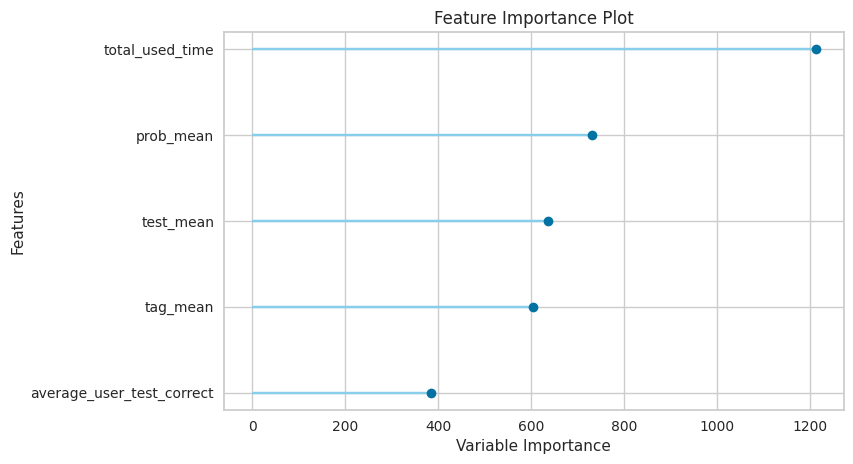

In [40]:
plot_model(estimator = model, plot = 'feature')



# Inference

In [41]:
# MAKE PREDICTION
# SAVE OUTPUT

prediction = predict_model(model, data=df_shift[FEATS], raw_score=True)
# prediction = predict_model(model, data=df_test_shift[FEATS], raw_score=True)
total_preds = prediction.Score_1.values

prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

name = ('filter_option', 'train_must_exist_leaderboard', 'FEATS', 'log')
logs = (filter_option, train_must_exist_leaderboard, FEATS,log)
write_path = os.path.join(output_dir, f"{prediction_name}_log.txt")
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    for n, l in zip(name, logs):
        w.write(f'{n}: {l}\n')

writing prediction : /opt/ml/p4-dkt-feedgate/lgbm_output/서일님/0615_1108.csv
writing prediction : /opt/ml/p4-dkt-feedgate/lgbm_output/서일님/0615_1108_log.txt
